In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import requests
import json
import geopandas as gpd
from tqdm import tqdm
import numpy as np
import fnmatch
import osmnx as ox
import networkx as nx
import itertools
import multiprocessing as mp
import sys
sys.path.append('..')
import utils

# 1. Supply (Hospital)

In [5]:
# Define paths
data = '../data'
supply = os.path.join(data, 'original_data', 'supply_related')
demand = os.path.join(data, 'original_data', 'demand_related')

result = os.path.join(data, 'access', 'input_files')

## 1.1. Hospital locations

In [6]:
# Supply (Hospital Locations; Definitive healthcare)
# https://www.arcgis.com/home/item.html?id=5d43b66c248b4b3cbef4ad516189a53d
definitive = pd.read_excel(os.path.join(supply, 'Definitive_Healthcare_Bed_Locations.xlsx'))
definitive = definitive.loc[definitive['State Abrv'] == 'TX']
definitive = definitive[['Hospital Name', 'Hospital Type', 'Address', 
                         'City', 'State Abrv', 'Zip Code', 'County Name', '# of Staffed Beds', '# of ICU Beds'
                        ]]
definitive = definitive.rename(columns={'Hospital Name': 'Name',
                                        'Hospital Type': 'Type',
                                        'State Abrv': 'State', 
                                        'Zip Code': 'Zip', 
                                        'County Name': 'County',
                                        '# of Staffed Beds': 'Staffed_Beds', 
                                        '# of ICU Beds': 'ICU_Beds'
                                       })
definitive = definitive.sort_values('Zip')
definitive = definitive.reset_index(drop=True)

# Merge TSA info
tsa = pd.read_json(os.path.join(data, 'original_data' ,'tsa_county.json'))
definitive = definitive.merge(tsa, on='County')
definitive.head(3)

,Name,Type,Address,City,State,Zip,County,Staffed_Beds,ICU_Beds,FIPS,TSA
0,Methodist Hospital for Surgery,Short Term Acute Care Hospital,17101 Dallas Pkwy,Addison,TX,75001,Dallas,32.0,4,48113,E
1,Legent Orthopedic Hospital,Short Term Acute Care Hospital,1401 E Trinity Mills Rd,Carrollton,TX,75006,Dallas,NaN,0,48113,E
2,Medical City Las Colinas (FKA Las Colinas Medi...,Short Term Acute Care Hospital,6800 N MacArthur Blvd,Irving,TX,75039,Dallas,80.0,8,48113,E


In [7]:
# Google API Geocoding
# url = 'https://maps.googleapis.com/maps/api/geocode/json?'
# keys = 'API_KEY'

# definitive['lat'] = 0.0
# definitive['lng'] = 0.0
# definitive['coord_type'] = ''
# definitive['format_addr'] = ''

# for idx, row in tqdm(definitive.iterrows(), total=definitive.shape[0]):
#     string = f"{row['Address']}+{row['City']}+{row['State']}+{row['Zip']}"
#     string = string.replace(' ', '+')

#     # Final URL for querying
#     query = url + 'address=' + string + '&key=' + keys
#     api_response = requests.get(query)
#     api_results = json.loads(api_response.text)
    
#     if api_results['status'] == 'OK':
#         if len(api_results['results']) != 1:
#             print(f"duplicated results for {string.replace('+', ' ')}")
#             continue
        
#         else:
#             lat = api_results['results'][0]['geometry']['location']['lat']
#             lng = api_results['results'][0]['geometry']['location']['lng']
#             format_addr = api_results['results'][0]['formatted_address']
#             types = api_results['results'][0]['types']
            
#             definitive.at[idx, 'lng'] = lng
#             definitive.at[idx, 'lat'] = lat
#             definitive.at[idx, 'format_addr'] = format_addr
#             definitive.at[idx, 'coord_type'] = types

#     else:
#         print(f"Fail for {string.replace('+', ' ')}")
# #     print(query)

# def change_to_string(val):
#     if len(str(val)) == 1:
#         return 'H00'+ str(val)
#     elif len(str(val)) == 2:
#         return 'H0'+str(val)
#     elif len(str(val)) == 3:
#         return 'H'+str(val)
#     else:
#         raise AttributeError


# # Convert Geocoded hospitals to GeoJSON
# definitive['HC_ID'] = definitive.apply(lambda x:change_to_string(x['Unnamed: 0']), axis=1)
# definitive = definitive[['HC_ID', 'Type', 'Zip', 'County', 'Staffed_Beds', 'ICU_Beds', 'FIPS', 'TSA', 'lat', 'lng']]
# definitive = gpd.GeoDataFrame(definitive, geometry=gpd.points_from_xy(definitive.lng, definitive.lat))
# definitive = definitive.set_crs(epsg=4326)
# definitive = definitive.to_crs(epsg=3081)
# definitive.to_file(os.path.join(result, 'hospital_geocode.json'))

## 1.2. Supply Availability

In [8]:
# Calculate focus date
from_date = '07/01/2020'
to_date = '12/31/2021'

start_date = datetime.datetime.strptime(from_date,  "%m/%d/%Y")
end_date = datetime.datetime.strptime(to_date,  "%m/%d/%Y")

focus_date = []
delta = datetime.timedelta(days=1)
while start_date <= end_date:
    focus_date.append(start_date.strftime("%m/%d/%Y"))
    start_date += delta
    
# Make a dictionary that has keys as target date and values as the date that should be averaged. 
focus_date_dict = {}
time_delta = [3, 2, 1, 0, -1, -2, -3]

for idx, date in enumerate(focus_date):
    temp_list = []
    for delta in time_delta:
        temp_list.append(
            str(
                (datetime.datetime.strptime(focus_date[idx], "%m/%d/%Y") - datetime.timedelta(days=delta)
                ).strftime("%m/%d/%Y"))
        )
        
    focus_date_dict[date] = temp_list
    
# Manually enter the dates that would have missing values
focus_date_dict['07/01/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020']
focus_date_dict['07/02/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020', '07/05/2020']
focus_date_dict['07/03/2020'] = ['07/01/2020', '07/02/2020', '07/03/2020', '07/04/2020', '07/05/2020', '07/06/2020']
focus_date_dict['12/29/2021'] = ['12/26/2021', '12/27/2021', '12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
focus_date_dict['12/30/2021'] = ['12/27/2021', '12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
focus_date_dict['12/31/2021'] = ['12/28/2021', '12/29/2021', '12/30/2021', '12/31/2021']
# focus_date_dict

In [30]:
# ICU Beds Available
icu_open = pd.read_excel(os.path.join(supply, 'Combined Hospital Data over Time by TSA Region.xlsx'), 
                         sheet_name='Adult ICU Beds Available',
                         header=2,
                         index_col=0
                        )
icu_open = icu_open.loc['A.':'V.', focus_date]
icu_open.index = [idx[0] for idx in icu_open.index]

# ICU Beds Occupied
icu_occu = pd.read_excel(os.path.join(supply, 'Combined Hospital Data over Time by TSA Region.xlsx'), 
                         sheet_name='ICU Beds Occupied',
                         header=2,
                         index_col=0
                        )
icu_occu = icu_occu.loc['A.':'V.', focus_date]
icu_occu.index = [idx[0] for idx in icu_occu.index]

# ICU Beds Occupied with COVID-19 Patients
icu_covid = pd.read_excel(os.path.join(supply, 'Combined Hospital Data over Time by TSA Region.xlsx'), 
                         sheet_name='Adult COVID-19 ICU',
                         header=2,
                         index_col=0
                        )
icu_covid = icu_covid.loc['A.':'V.', focus_date]
icu_covid.index = [idx[0] for idx in icu_covid.index]

icu_avail = (icu_open + icu_covid) / (icu_open_mean + icu_occu_mean)
icu_avail

# 7days mean
icu_avail_mean = icu_avail.copy(deep=True)

for date in focus_date:
    icu_avail_mean[date] = icu_avail[focus_date_dict[date]].mean(axis=1)
    
for date in focus_date:
    icu_avail_mean[date] = icu_avail_mean[date].mask(icu_avail_mean[date] > 1, 1)
    
icu_avail_mean.to_csv(os.path.join(result, 'ICU_beds_available_ratio.csv'))

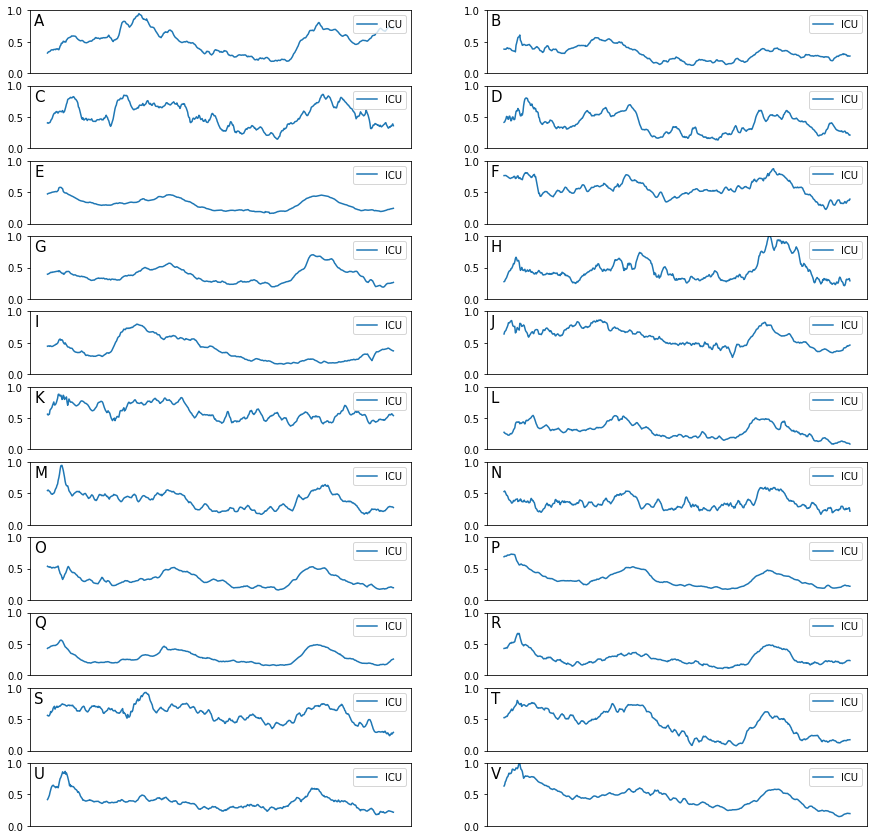

In [31]:
# Examine temporal changes of availability of ICU beds and General beds

tsas = tsa['TSA'].unique()
tsas.sort()

fig, axes = plt.subplots(11, 2, figsize=(15, 15))
for idx, ax in enumerate(axes.reshape(-1)):
    ax.text(0.01, 0.95, tsas[idx], transform=ax.transAxes, fontsize=15, ha='left', va='top')
    icu_avail_mean.loc[tsas[idx]].plot(ax=ax, label='ICU')
    ax.legend(loc='upper right')
    ax.set_ylim(0, 1)
    ax.get_xaxis().set_visible(False)


# 2. Demand (Estimated COVID-19 Confirmed Case per Census Tract)
## 2.1. Population ratio of Each Census Tract based on County Population

In [32]:
# https://data.census.gov/cedsci/table?q=Population%20Total&g=0400000US48%241400000&tid=ACSDT5Y2019.B01003
acs_tract = pd.read_csv(os.path.join(demand, 'ACSDT5Y2019.B01003_2022-02-21T221149/ACSDT5Y2019.B01003_data_with_overlays_2022-02-21T221145.csv'))
acs_tract = acs_tract.loc[1:, ['GEO_ID', 'NAME', 'B01003_001E']]
acs_tract['GEOID'] = acs_tract.apply(lambda x:str(x['GEO_ID'][9:]), axis=1)
acs_tract['FIPS'] = acs_tract.apply(lambda x:x['GEOID'][0:5], axis=1)
acs_tract['CTID'] = acs_tract.apply(lambda x:x['GEOID'][5:], axis=1)
acs_tract['B01003_001E'] = acs_tract['B01003_001E'].astype(int)
acs_tract = acs_tract.rename(columns={'B01003_001E': 'Tract_Pop'})
acs_tract = acs_tract.drop(columns=['GEO_ID', 'NAME'])
acs_tract

,Tract_Pop,GEOID,FIPS,CTID
1,4844,48001950100,48001,950100
2,4838,48001950401,48001,950401
3,7511,48001950402,48001,950402
4,4465,48001950500,48001,950500
5,5148,48001950600,48001,950600
...,...,...,...,...
5261,5399,48505950400,48505,950400
5262,1448,48507950100,48507,950100
5263,1608,48507950200,48507,950200
5264,2085,48507950301,48507,950301


In [33]:
acs_county = acs_tract.groupby('FIPS').sum()

acs_tract['Pop_Ratio'] = 0.0
acs_tract['County_Pop'] = 0.0
for idx, row in tqdm(acs_tract.iterrows(), total=acs_tract.shape[0]):
    acs_tract.at[idx, 'County_Pop'] =  acs_county.loc[row['FIPS'], 'Tract_Pop']
    acs_tract.at[idx, 'Pop_Ratio'] = row['Tract_Pop'] / acs_county.loc[row['FIPS'], 'Tract_Pop']
    
acs_tract

100%|██████████████████████████████████| 5265/5265 [00:00<00:00, 19381.42it/s]


,Tract_Pop,GEOID,FIPS,CTID,Pop_Ratio,County_Pop
1,4844,48001950100,48001,950100,0.083792,57810.0
2,4838,48001950401,48001,950401,0.083688,57810.0
3,7511,48001950402,48001,950402,0.129926,57810.0
4,4465,48001950500,48001,950500,0.077236,57810.0
5,5148,48001950600,48001,950600,0.089050,57810.0
...,...,...,...,...,...,...
5261,5399,48505950400,48505,950400,0.377447,14304.0
5262,1448,48507950100,48507,950100,0.120276,12039.0
5263,1608,48507950200,48507,950200,0.133566,12039.0
5264,2085,48507950301,48507,950301,0.173187,12039.0


## 2.2. Accumulate Confirmed Cases

In [34]:
# Calculate focus date for confirmed case calculation
from_date = '2020-05-01'
to_date = '2021-12-31'

start_date = datetime.datetime.strptime(from_date,  "%Y-%m-%d")
end_date = datetime.datetime.strptime(to_date,  "%Y-%m-%d")

focus_date = []
focus_date_demand = []
delta = datetime.timedelta(days=1)
while start_date <= end_date:
    focus_date.append(start_date.strftime("%m/%d/%Y"))
    focus_date_demand.append(start_date.strftime("%Y-%m-%d"))
#     focus_date_demand.append(start_date.strftime("%m/%d/%Y"))
    start_date += delta
    

# Make a dictionary that has keys as target date and values as the date that should be averaged. 
focus_date_dict = {}
time_delta = list(range(0, -25, -1))

for idx, date in enumerate(focus_date):
    temp_list = []
    for delta in time_delta:
        temp_list.append(
            str(
                (datetime.datetime.strptime(focus_date[idx], "%m/%d/%Y") + datetime.timedelta(days=delta)
                ).strftime("%m/%d/%Y"))
        )
        
    focus_date_dict[date] = temp_list

# Remove days in May from the dictionary, given that it is not the focus date of our analysis. 
may_date = fnmatch.filter(focus_date_dict.keys(), '05/??/2020')

for date in may_date:
    del focus_date_dict[date]
    
# focus_date_dict

In [35]:
# Load daily confirmed case data
confirm_case = pd.read_excel(os.path.join(demand, 'Texas COVID-19 New Confirmed Cases by County.xlsx'),
                             sheet_name='New Cases by County 2020',
                             header=2,
                             index_col=0)

confirm_case = confirm_case.loc['Anderson':'Zavala', focus_date]
confirm_case.columns = confirm_case.columns.astype(str)

# Remove negative value of confirmed cases. 
# Negative value has replaced with 0
for col in confirm_case.columns:
    confirm_case[col] = confirm_case[col].mask(confirm_case[col] < 0, 0)

rename_lookup = dict(zip(focus_date_demand, focus_date))
confirm_case = confirm_case.rename(columns=rename_lookup, errors='raise')
    
confirm_case

,05/01/2020,05/02/2020,05/03/2020,05/04/2020,05/05/2020,05/06/2020,05/07/2020,05/08/2020,05/09/2020,05/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
County,,,,,,,,,,,,,,,,,,,,,
Anderson,5.0,2.0,0.0,15.0,14.0,13.0,42.0,12.0,8.0,5.0,...,1.0,6.0,2.0,7.0,3.0,7.0,4.0,13.0,4.0,4.0
Andrews,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,10.0,5.0,0.0,0.0,0.0,0.0,16.0,27.0,16.0
Angelina,1.0,1.0,0.0,4.0,11.0,1.0,3.0,2.0,0.0,0.0,...,1.0,7.0,6.0,6.0,7.0,9.0,9.0,11.0,7.0,23.0
Aransas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,5.0,2.0,1.0,9.0,0.0,1.0,4.0
Archer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,6.0,3.0,2.0,2.0,3.0,11.0,3.0,2.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,3.0,3.0,2.0,8.0,1.0,9.0,1.0,6.0,1.0,2.0
Yoakum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Young,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,1.0,8.0,1.0,1.0,3.0


2.5002078876079055 18.705041808034178
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 0.996, 0.989, 0.97, 0.931, 0.86, 0.753, 0.611, 0.453, 0.302, 0.179, 0.094, 0.043, 0.017, 0.006]


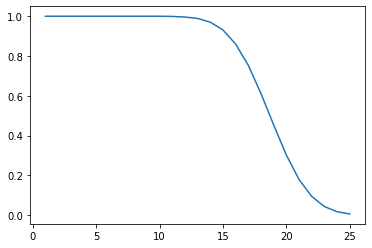

In [36]:
# Theoretical background of accumulating case
# Recovery date from COVID-19 for worse symptom: 18.70±2.50
# https://onlinelibrary.wiley.com/doi/pdf/10.1111/joim.13063

group = np.random.normal(loc=18.70,scale=2.5,size=1000000)
print(group.std(),group.mean())

stat_pop = 1000000
acc_ratio = []

for days in range(1, 26, 1):
    temp_array = group > days
    acc_ratio.append(round(temp_array.sum() / stat_pop, 3))
#     print(days, round(temp_array.sum() / stat_pop, 3))
plt.plot(range(1, 26), acc_ratio)
print(acc_ratio)

In [37]:
# Calculate accumulate case per county
acc_confirm_case = confirm_case.copy(deep=True)
for date in tqdm(focus_date_dict.keys()):
    
    acc_case_list = []
    for idx, date_ in enumerate(focus_date_dict[date]):
        acc_case_list.append(confirm_case[date_] * acc_ratio[idx])
    
    acc_confirm_case[date] = sum(acc_case_list)

acc_confirm_case = acc_confirm_case[focus_date_dict.keys()]
acc_confirm_case 

100%|██████████████████████████████████████| 579/579 [00:01<00:00, 517.80it/s]


,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,06/09/2020,06/10/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
County,,,,,,,,,,,,,,,,,,,,,
Anderson,27.403,59.485,55.336,69.022,75.456,74.440,72.828,72.529,75.513,79.765,...,38.118,41.473,40.934,45.495,46.090,50.725,52.394,63.214,65.237,67.510
Andrews,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,65.412,72.469,74.291,70.883,67.288,63.630,59.987,72.294,95.487,107.404
Angelina,21.804,20.075,18.287,69.423,83.518,87.657,85.966,87.538,110.417,126.521,...,31.695,37.177,41.646,46.181,51.798,59.537,67.432,77.485,83.668,105.886
Aransas,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.000,...,24.451,24.303,23.313,26.476,26.794,26.303,34.065,33.049,33.164,36.349
Archer,0.179,0.094,0.043,0.017,2.006,2.000,2.000,2.000,2.000,2.000,...,34.857,38.488,39.091,38.846,38.819,40.051,49.528,51.230,52.092,62.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,0.043,0.017,0.006,2.000,5.000,5.000,5.000,5.000,7.000,8.000,...,74.144,75.149,75.279,81.364,80.185,86.562,84.464,86.921,84.086,82.090
Yoakum,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,15.008,14.337,14.573,13.699,12.707,11.637,11.540,11.444,10.338,9.166
Young,0.000,0.000,0.000,1.000,2.000,2.000,2.000,5.000,9.000,10.000,...,60.086,57.610,55.507,52.557,47.653,43.025,45.223,40.754,37.009,35.977


In [38]:
# Add FIPS-County pair to the dataframe
tsa = pd.read_json(os.path.join(data, 'original_data' ,'tsa_county.json'))
tsa = tsa.set_index('County')

acc_confirm_case = acc_confirm_case.merge(tsa, left_index=True, right_index=True)
acc_confirm_case['FIPS'] = acc_confirm_case['FIPS'].astype(str)
acc_confirm_case

,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,06/08/2020,06/09/2020,06/10/2020,...,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021,FIPS,TSA
County,,,,,,,,,,,,,,,,,,,,,
Anderson,27.403,59.485,55.336,69.022,75.456,74.440,72.828,72.529,75.513,79.765,...,40.934,45.495,46.090,50.725,52.394,63.214,65.237,67.510,48001,G
Andrews,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,74.291,70.883,67.288,63.630,59.987,72.294,95.487,107.404,48003,J
Angelina,21.804,20.075,18.287,69.423,83.518,87.657,85.966,87.538,110.417,126.521,...,41.646,46.181,51.798,59.537,67.432,77.485,83.668,105.886,48005,H
Aransas,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.000,...,23.313,26.476,26.794,26.303,34.065,33.049,33.164,36.349,48007,U
Archer,0.179,0.094,0.043,0.017,2.006,2.000,2.000,2.000,2.000,2.000,...,39.091,38.846,38.819,40.051,49.528,51.230,52.092,62.023,48009,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wood,0.043,0.017,0.006,2.000,5.000,5.000,5.000,5.000,7.000,8.000,...,75.279,81.364,80.185,86.562,84.464,86.921,84.086,82.090,48499,G
Yoakum,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,14.573,13.699,12.707,11.637,11.540,11.444,10.338,9.166,48501,B
Young,0.000,0.000,0.000,1.000,2.000,2.000,2.000,5.000,9.000,10.000,...,55.507,52.557,47.653,43.025,45.223,40.754,37.009,35.977,48503,C


In [39]:
# Anticipated COVID-19 case per census tract
county_codes = acs_county.index.to_list()
acs_tract_case = acs_tract.copy(deep=True)

for date in tqdm(focus_date_dict.keys()):
    temp_df = acc_confirm_case[[date, 'FIPS']]
    acs_tract_case = acs_tract_case.merge(temp_df, on='FIPS')
    acs_tract_case[date] = acs_tract_case[date] * acs_tract_case['Pop_Ratio']

acs_tract_case.to_csv(os.path.join(result, 'estimated_covid_case.csv'), index=False)
acs_tract_case

100%|███████████████████████████████████████| 579/579 [00:06<00:00, 92.11it/s]


,Tract_Pop,GEOID,FIPS,CTID,Pop_Ratio,County_Pop,06/01/2020,06/02/2020,06/03/2020,06/04/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
0,4844,48001950100,48001,950100,0.083792,57810.0,2.296145,4.984351,4.636699,5.783473,...,3.193973,3.475094,3.429931,3.812105,3.861961,4.250336,4.390184,5.296811,5.466321,5.656780
1,4838,48001950401,48001,950401,0.083688,57810.0,2.293301,4.978177,4.630956,5.776309,...,3.190017,3.470790,3.425682,3.807383,3.857177,4.245071,4.384746,5.290250,5.459550,5.649773
2,7511,48001950402,48001,950402,0.129926,57810.0,3.560352,7.728625,7.189564,8.967726,...,4.952505,5.388405,5.318375,5.910966,5.988272,6.590477,6.807323,8.213118,8.475958,8.771278
3,4465,48001950500,48001,950500,0.077236,57810.0,2.116492,4.594370,4.273919,5.330967,...,2.944073,3.203199,3.161569,3.513841,3.559797,3.917785,4.046691,4.882382,5.038630,5.214187
4,5148,48001950600,48001,950600,0.089050,57810.0,2.440246,5.297159,4.927689,6.146432,...,3.394421,3.693185,3.645187,4.051345,4.104330,4.517078,4.665703,5.629228,5.809377,6.011788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5260,5399,48505950400,48505,950400,0.377447,14304.0,1.121017,1.483744,1.456945,1.416558,...,3.540074,3.068266,3.025237,3.036560,3.489496,3.250195,5.334834,5.200463,5.097420,5.012872
5261,1448,48507950100,48507,950100,0.120276,12039.0,0.021650,0.009261,0.003488,0.120997,...,2.325171,2.307611,2.523506,2.366426,2.209947,2.307370,2.191545,2.346580,2.404192,2.590018
5262,1608,48507950200,48507,950200,0.133566,12039.0,0.024042,0.010285,0.003873,0.134367,...,2.582096,2.562596,2.802346,2.627909,2.454140,2.562328,2.433704,2.605871,2.669849,2.876208
5263,2085,48507950301,48507,950301,0.173187,12039.0,0.031174,0.013335,0.005022,0.174226,...,3.348054,3.322769,3.633639,3.407457,3.182141,3.322422,3.155643,3.378881,3.461838,3.729412


# 2.3. Merge the accumulated COVID-19 case per Census tract to SHP

In [40]:
# Speicfy index
acs_tract_case['GEOID'] = acs_tract_case['GEOID'].astype(str)
acs_tract_case = acs_tract_case.set_index('GEOID')

# https://www2.census.gov/geo/tiger/TIGER2019/TRACT/
tract_shp = gpd.read_file(os.path.join(demand, 'tl_2019_48_tract', 'tl_2019_48_tract.shp'))
tract_shp = tract_shp[['GEOID', 'geometry']]
tract_shp['FIPS'] = tract_shp.apply(lambda x:str(x['GEOID'][0:5]), axis=1)
tract_shp['CTID'] = tract_shp.apply(lambda x:str(x['GEOID'][6:]), axis=1)
tract_shp['GEOID'] = tract_shp['GEOID'].astype(str)
tract_shp = tract_shp.set_index('GEOID')

# Merge two files
tract_shp = tract_shp.merge(acs_tract_case[focus_date_dict.keys()], left_index=True, right_index=True)
tract_shp.to_file(os.path.join(result, 'accumulated_covid_case_per_tract.shp'))
tract_shp.head(3)

,geometry,FIPS,CTID,06/01/2020,06/02/2020,06/03/2020,06/04/2020,06/05/2020,06/06/2020,06/07/2020,...,12/22/2021,12/23/2021,12/24/2021,12/25/2021,12/26/2021,12/27/2021,12/28/2021,12/29/2021,12/30/2021,12/31/2021
GEOID,,,,,,,,,,,,,,,,,,,,,
48439121609,"POLYGON ((-97.23369 32.67175, -97.23366 32.671...",48439,21609,3.374094,3.264494,3.272251,4.140405,4.457649,4.365577,4.254873,...,12.945244,13.754845,14.890598,16.674960,17.242543,19.741694,21.039525,22.027648,23.293796,25.984976
48187210708,"POLYGON ((-98.26254 29.57872, -98.26236 29.578...",48187,10708,0.590830,0.774624,0.837613,1.286483,1.570166,1.650939,1.608829,...,9.400120,9.914525,10.227587,11.068333,11.417786,12.727146,13.360124,14.025420,14.951914,15.850086
48201550301,"POLYGON ((-95.43727 29.98103, -95.43709 29.981...",48201,50301,13.295917,13.382840,13.337512,14.933455,15.526157,15.374576,14.890228,...,39.209440,45.305836,51.826708,57.598097,63.505045,71.156788,74.524647,80.295472,84.107999,88.526641


<AxesSubplot:>

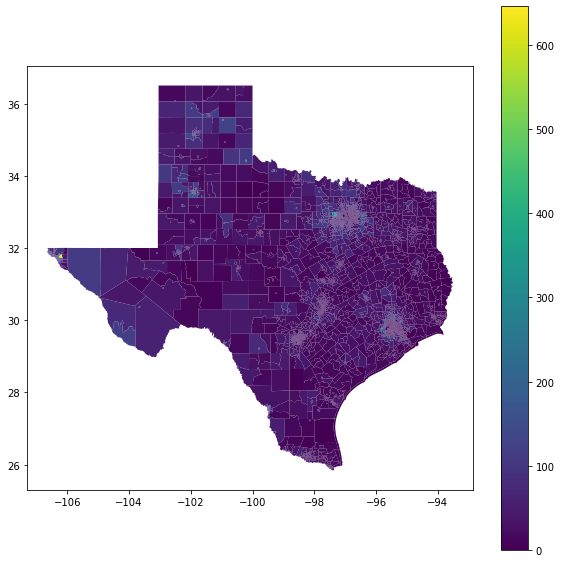

In [41]:
tract_shp.plot('12/01/2020', figsize=(10, 10), legend=True)

# 3. Mobility: Estimated travel time between hospital and census tracts
## 3.1. Obtain OSM network from OSMnx 

In [ ]:
def road_network_setting(network):

    for u, v, k, data in network.edges(data=True, keys=True):

        data['length'] = data['geometry'].length  # Calculate the exact length of edges based on the CRS 26971
        if 'maxspeed' in data.keys():
#             print(data['maxspeed'], type(data['maxspeed']))
            if type(data['maxspeed']) == list:
                list_speed = data['maxspeed'][0]  # extract only numbers
            elif type(data['maxspeed']) == str:
                if len(data['maxspeed'].split()) == 2: 
                    if data['maxspeed'].split()[1] == 'mph': # if the format is 'xx mph'
                        temp_speed = data['maxspeed'].split()[0]  # extract only numbers
                elif len(data['maxspeed'].split()) == 1 and int(data['maxspeed']) != 0: 
                    temp_speed = data['maxspeed']
                else:
                    temp_speed = assign_max_speed_with_highway_type(data)
            else: # If the type is either int or float
                if data['maxspeed'] == 0: # If the entry is 0 although the type is valid. 
                    temp_speed = assign_max_speed_with_highway_type(data)
                else:
                    pass
            try:
                data['maxspeed'] = int(temp_speed)
            except:
                temp_speed = assign_max_speed_with_highway_type(data)
                data['maxspeed'] = int(temp_speed)
                

        else:
            temp_speed = assign_max_speed_with_highway_type(data)
            data['maxspeed'] = int(temp_speed)
        

        data['maxspeed_meters'] = data['maxspeed'] * 26.8223 # MPH * 1.6 * 1000 / 60; meter per minute
        data['time'] = float(data['length'] / data['maxspeed_meters'])
    
    return network


def assign_max_speed_with_highway_type(row_):
    """
    Assign the maximum speed of an edge based on its attribute 'highway'
    
    Args:
        row_: (dict) a row of OSMnx network data
    
    Returns:
        temp_speed_: (int) the maximum speed of an edge
    
    """
    
    max_speed_per_type = {'motorway': 70, 
              'motorway_link': 40, 
              'trunk': 70,
              'trunk_link': 30, 
              'primary': 50,
              'primary_link': 30, 
              'secondary': 50,
              'secondary_link': 30, 
              'tertiary': 40, 
              'tertiary_link': 20,
              'residential': 30,
              'living_street': 20,
              'unclassified': 20
             }
    
    # if the variable is a list, obtain just the first one. 
    if type(row_['highway']) == list: 
        road_type = row_['highway'][0]
    else:
        road_type = row_['highway']
    
    # If the maximum speed of the road_type is predefined.
    if road_type in max_speed_per_type.keys():
        temp_speed_ = max_speed_per_type[road_type]
    else: # If not defined, just use 20 mph. 
        temp_speed_ = 20
    
    return temp_speed_

In [ ]:
# Download OSM Network based on the shape of each county
counties = gpd.read_file(os.path.join(demand, 'tl_2021_48_county/tl_2021_48_county.shp'))

for idx, row in tqdm(counties.iterrows(), total=counties.shape[0]):
    if os.path.exists(os.path.join(data, f'original_data/OSM_Network/OSM_{row["GEOID"]}.graphml')):
        print(idx, f'{row["NAME"]}', f'OSM_{row["GEOID"]}.graphml')
    
    else:
        print(idx, f'{row["NAME"]}, {row["GEOID"]}')
        aoi = row['geometry'].buffer(0.01)
        G = ox.graph_from_polygon(aoi, network_type='drive', simplify=True)
        G = ox.projection.project_graph(G, to_crs='epsg:3081')
        G = road_network_setting(G)
        ox.save_graphml(G, os.path.join(data, f'original_data/OSM_Network/OSM_{row["GEOID"]}.graphml'))
    

## 3.2. Calculate OD Matrix
### 3.2.1. Set up predefined locations with a simple buffer for calculating a detailed OD Matrix

In [ ]:
dist = 100 * 1.6 * 1000 # unit: meter
dist

In [ ]:
census_tract = gpd.read_file(os.path.join(demand, 'tl_2019_48_tract', 'tl_2019_48_tract_epsg_3081.shp'))
census_tract = census_tract.set_index('GEOID')
print(census_tract.crs)
census_tract.head()

In [ ]:
hospitals = gpd.read_file(os.path.join(result, 'hospital_geocode.json'))
hospitals = hospitals.set_index('HC_ID')
hospitals['FIPS'] = hospitals['FIPS'].astype(str)
print(hospitals.crs)
hospitals.head()

In [ ]:
within_dist = pd.DataFrame(list(itertools.product(hospitals.index, census_tract.index)), columns=['HC_ID', 'GEOID'])
within_dist['dist'] = -999

for idx_s, row_s in tqdm(hospitals.iterrows(), total=hospitals.shape[0]):
    temp_buffer = census_tract.loc[census_tract.geometry.intersects(row_s['geometry'].buffer(dist))]

    within_dist.loc[(within_dist['HC_ID'] == idx_s) & (within_dist['GEOID'].isin(temp_buffer.index)), 'dist'] = 0

within_dist = within_dist.loc[within_dist['dist'] == 0]
within_dist['trvl_time'] = -999

In [ ]:
# Following cell was run on Keeling due to multiprocessing capability (see 'Calculate_OD_Matrix.py'). 
# Keeling will save the file in 'data/original_data/OD_Matrix'
# Hospitals_in_{fips_}.csv : OD Matrix for census tracts that are within 16 KM of a county (fips_)
# Hospitals_in_{fips_}_non.csv : OD Matrix for census tracts that are NOT within 16 KM of a county (fips_)

if __name__ == "__main__":
    pool = mp.Pool(8)
    pool.map(utils.local_OD_Matrix_unpacker,
             zip(hospitals['FIPS'].unique().tolist(),
                 #['48001', '48003', '48013', '48015', '48017', '48023', '48025', '48035'],
                 itertools.repeat(hospitals),
                 itertools.repeat(census_tract),
                 itertools.repeat(within_dist)
                 )
             )
    pool.close()

### 3.2.2. Append remotely calculated OD_Matrix

In [ ]:
trvl_time_df = pd.DataFrame(columns=['HC_ID', 'GEOID', 'dist', 'trvl_time'])

for fips_ in hospitals['FIPS'].unique():
    temp_df = pd.read_csv(f'./data/original_data/OD_Matrix/Hospitals_in_{fips_}.csv')
    trvl_time_df = pd.concat([trvl_time_df, temp_df])
    
trvl_time_df = trvl_time_df.drop(columns=['dist', 'Unnamed: 0'])
trvl_time_df

In [ ]:
trvl_time_df.to_csv(os.path.join(result, 'Precalculated_OD_Matrix.csv'), index=False)